In [2]:
# !kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis
# !unzip -a twitter-entity-sentiment-analysis.zip

# EDA:
Before designing a model, lets get an idea of the data in the training dataset.

In [29]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data import random_split
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
train = pd.read_csv("twitter_training.csv")
val = pd.read_csv('twitter_validation.csv')

In [5]:
train.head(-10)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74666,9198,Nvidia,Negative,Nvidia really delayed the 3070 several weeks.
74667,9198,Nvidia,Negative,Nvidia really only delayed the 3070 2 flight w...
74668,9198,Nvidia,Negative,Nvidia really delayed the next 2 weeks.
74669,9199,Nvidia,Positive,Let no elim go unnoticed. . . . NVIDIA Highlig...


# First Impressions
The data is not really organized into columns, so I will need to do some preproccessing for that. <br>
Secondly, it seems like some of the data is containing the UNK key which means I'll need to pull that out.

In [6]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
# nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mhrrs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
train.columns=['id', 'subject', 'sentiment', 'text']
val.columns=['id', 'subject', 'sentiment', 'text']
train.head()

,id,subject,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
# Assuming that `train` is a pandas DataFrame, you can use the `value_counts` function on the 'sentiment' column to get the quantity of each unique sentiment value.

sentiment_counts = train['sentiment'].value_counts()
sentiment_counts


Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: sentiment, dtype: int64

In [9]:
train['lower'] = train.text.str.lower()
train['lower'] = [str(data) for data in train.lower]
val['lower'] = val.text.str.lower()
val['lower'] = [str(data) for data in val.lower]
train["lower"]=train.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
val["lower"]=val.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

In [10]:
val.head()

,id,subject,sentiment,text,lower
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon boss jeff bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,microsoft why do i pay for word when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking is so full of closet hacking ...
3,4433,Google,Neutral,Now the President is slapping Americans in the...,now the president is slapping americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,hi eahelp i ve had madeleine mccann in my cel...


In [11]:
#Count information per category
plot1=train.groupby(by=["subject","sentiment"]).count().reset_index()
plot1.head()

,subject,sentiment,id,text,lower
0,Amazon,Irrelevant,192,186,192
1,Amazon,Negative,576,575,576
2,Amazon,Neutral,1236,1207,1236
3,Amazon,Positive,312,308,312
4,ApexLegends,Irrelevant,192,192,192


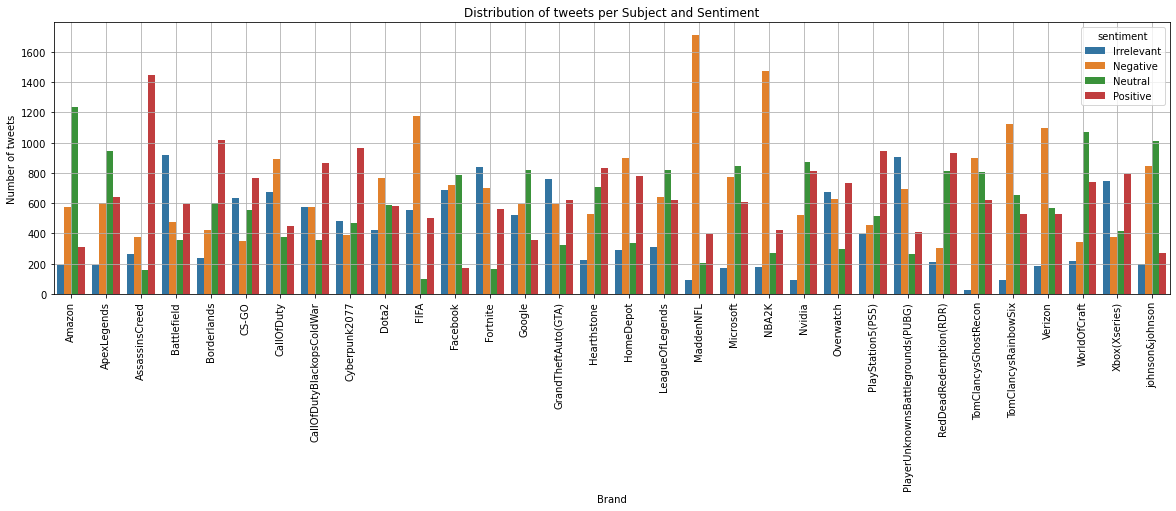

In [12]:
#Figure of comparison per branch
plt.figure(figsize=(20,5))
sns.barplot(data=plot1,x="subject",y="id",hue="sentiment")
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Subject and Sentiment");

In [14]:
# tokenizing the sentence to just obtain the words.
tokens_text = [word_tokenize(str(sentence)) for sentence in train.text]
val_tokens_text = [word_tokenize(str(sentence)) for sentence in val.text]

In [15]:
# converting text of labels into index values
sentiment_to_index = {"Positive": 0, "Neutral": 1, "Negative":2, "Irrelevant": 3}
labels = []
for value in train["sentiment"]:
    data = [sentiment_to_index[value]]
    labels.append(data)

val_labels = []
for value in val["sentiment"]:
    data = [sentiment_to_index[value]]
    val_labels.append(data)

In [16]:
# converting text of words into index values and vocab var
words = [word for token_sentence in tokens_text for word in token_sentence]
stop_words = set(stopwords.words('english'))
words = [word for word in words if word not in stop_words]
words = [word for word in words if word.isalpha()]
vocab = sorted(set(words))
word_to_index = {word: i for i, word in enumerate(vocab)}

In [17]:
vocab_size = len(word_to_index)
vocab_size

34367

A vocab size of 34367 is very large. It's best that we do a frequency count to cut it down and assign the cut words the token of UNK

In [18]:
from collections import Counter

# Get the frequency count
freq_count = Counter(str(word).lower() for sen in tokens_text for word in sen)

# Filter the counter
filtered_freq_count = {word: count for word, count in freq_count.items() if count > 8}

In [19]:
len(filtered_freq_count)

8571

In [20]:
words = [word for word in filtered_freq_count if word not in stop_words]
words = [word for word in words if word.isalpha()]
words = ['<UNK>'] + words + ['<PAD>']
word_to_index = {word: i for i, word in enumerate(words)}
len(words)

7772

In [21]:
# turn token_text into data that will be inserted into the model
index_corpus = []
for sen in tokens_text:
    data = [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sen]
    index_corpus.append(data)
print(index_corpus[0])

val_index_corpus = []
for sen in val_tokens_text:
    data = [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sen]
    val_index_corpus.append(data)
print(val_index_corpus[0])

[0, 0, 1, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0]
[0, 0, 0, 0, 466, 0, 0, 1073, 1742, 1174, 4096, 46, 0, 0, 0, 0, 0]


In [22]:
# pad the sequences
from torch.nn.utils.rnn import pad_sequence

padded_sentences = pad_sequence([torch.Tensor(sentence) for sentence in index_corpus], padding_value=word_to_index['<PAD>'])
labels = torch.Tensor(labels)
dataset = torch.utils.data.TensorDataset(padded_sentences.t(), labels)

val_padded_sentences = pad_sequence([torch.Tensor(sentence) for sentence in val_index_corpus], padding_value=word_to_index['<PAD>'])
val_labels = torch.Tensor(val_labels)
val_dataset = torch.utils.data.TensorDataset(val_padded_sentences.t(), val_labels)

train_loader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)

In [23]:
train_loader

In [99]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.fc = torch.nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, inputs, hidden): # input dim: [sentence_length, batch_size]
        
        embed = self.embedding(inputs) # embed dim: [sentence length, batch size, embedding dim]
        
        output, hidden = self.lstm(embed, hidden) 
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch_size, hidden_dim]
        output = output[:,-1]
        
        output = self.fc(output)
        return output
    
    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.num_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.num_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden

In [110]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 4

RANDOM_SEED = 123
LR = .001
BATCH_SIZE = 16
EPOCHS = 15

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [111]:
model = Model(vocab_size = len(words), embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=NUM_CLASSES, num_layers = 1)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

folder = "./model"
filename = "model_1"
if not os.path.exists(folder):
    os.mkdir(folder)
    
filename = os.path.join(folder, filename)

In [112]:
for epoch in range(EPOCHS):
    idx = 0
    for batch in train_loader:
        inputs, labels = batch
        print(f"{idx} : {inputs.shape} : {labels.shape}")
        break
        
    idx +=1
        
    break

0 : torch.Size([16, 198]) : torch.Size([16, 1])


In [113]:
model.train()
for epoch in range(EPOCHS):
    h = model.init_hidden(batch_size=16)
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = torch.Tensor(inputs).long()
        labels = torch.Tensor(labels).long()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        hidden = tuple([each.data for each in h])
        
        labels = labels.squeeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs, hidden)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

    torch.save(model.state_dict(), filename)
    print(f"loss: {loss.item()} | accuracy:")

loss: 1.34331214427948 | accuracy:
loss: 1.3895421028137207 | accuracy:
loss: 1.3221336603164673 | accuracy:
loss: 1.419960618019104 | accuracy:
loss: 1.2947204113006592 | accuracy:
loss: 1.365169644355774 | accuracy:
loss: 1.1326171159744263 | accuracy:
loss: 0.7879151105880737 | accuracy:
loss: 0.8599667549133301 | accuracy:
loss: 0.45060810446739197 | accuracy:
loss: 0.16894222795963287 | accuracy:
loss: 0.20155450701713562 | accuracy:
loss: 0.45187681913375854 | accuracy:
loss: 0.46593695878982544 | accuracy:
loss: 0.6490437984466553 | accuracy:


In [115]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    hidden = model.init_hidden(16)
    for inputs, labels in val_loader:
        inputs = inputs.to(device).long()
        labels = labels.to(device).long()

        labels = labels.squeeze(1)
        preds = model(inputs, hidden)

        prediction = preds.argmax(dim=1)
        correct += (prediction == labels).sum().item()
        total += labels.size(0)

print(f"{correct/total}")

0.878763124062567


In [116]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    hidden = model.init_hidden(16)
    for inputs, labels in val_loader:
        inputs = inputs.to(device).long()
        labels = labels.to(device).long()

        labels = labels.squeeze(1)
        preds = model(inputs, hidden)

        prediction = preds.argmax(dim=1)

        all_labels.extend(labels.tolist())
        all_predictions.extend(prediction.tolist())

        correct += (prediction == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n {conf_matrix}")

Accuracy: 0.8787497321619885
Precision: 0.8873574251266627
Recall: 0.8787497321619885
F1 Score: 0.8797466397847
Confusion Matrix: 
 [[19235  1191   234   169]
 [ 1514 16474   217   111]
 [ 1762  1336 19256   186]
 [ 1141   947   246 10653]]


In [211]:
test_string = "I love Microsoft so fucking much"
test_tokens_text = [word_tokenize(str(sentence)) for sentence in val.text]

In [212]:
sentence_list = list(test_string)
data = [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence_list]
print(data)

[0, 0, 1190, 0, 449, 45, 0, 0, 0, 913, 591, 0, 0, 0, 898, 0, 0, 0, 0, 0, 898, 769, 913, 4042, 0, 975, 1042, 0, 0, 769, 913, 1511]


In [213]:
test_padded_sentences = pad_sequence([torch.Tensor(data)], padding_value=word_to_index['<PAD>'])

In [214]:
t_str = test_padded_sentences.t()
t_str

tensor([[   0.,    0., 1190.,    0.,  449.,   45.,    0.,    0.,    0.,  913.,
          591.,    0.,    0.,    0.,  898.,    0.,    0.,    0.,    0.,    0.,
          898.,  769.,  913., 4042.,    0.,  975., 1042.,    0.,    0.,  769.,
          913., 1511.]])

# REMEMBER:
# converting text of labels into index values
sentiment_to_index = {"Positive": 0, "Neutral": 1, "Negative":2, "Irrelevant": 3}

In [215]:
model.eval()
with torch.no_grad():
    inputs = t_str
    inputs = inputs.to(device)
    print(inputs.size())
    h = model.init_hidden(batch_size=1)
    prediction = model(inputs.long(), h)
    p = prediction.argmax(1)
    
print(p)

torch.Size([1, 32])
tensor([3], device='cuda:0')
